# Hierarchical modeling with the LKJ prior in PyMC

Throughout this blogpost, I will be working with the famous **sleepstudy** dataset. I'm going to estimate a **hierarchical linear regression** with both **varying intercepts** and **varying slopes**. The goal is to understand **how to place non-independent priors for the group-specific effects in PyMC** as efficiently as possible.

The sleepstudy dataset is derived from the study described in Belenky et al. (2003) and popularized in the lme4 R package. This dataset contains the **average reaction time** per day (in milliseconds) on a series of tests for the most sleep-deprived group in a sleep deprivation study. The first two days of the study are considered as adaptation and training, the third day is a baseline, and sleep deprivation started after day 3. The subjects in this group were restricted to 3 hours of sleep per night.

With that said, let's get into the code!

In [1]:
import arviz as az
import aesara.tensor as at
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
%matplotlib inline
az.style.use("arviz-darkgrid")
mpl.rcParams["figure.facecolor"] = "white"

Let's get started by downloading and exploring sleepstudy dataset.

In [3]:
url = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/lme4/sleepstudy.csv"
data = pd.read_csv(url, index_col = 0)

The following is a description of the variables we have in the dataset.

* **Reaction:** Average of the reaction time measurements on a given subject for a given day.
* **Days:** Number of days of sleep deprivation.
* **Subject:** The subject ID.

In [4]:
print(f"There are {len(data)} observations.")
data.head()

There are 180 observations.


Reaction  Days  Subject
1  249.5600     0      308
2  258.7047     1      308
3  250.8006     2      308
4  321.4398     3      308
5  356.8519     4      308

In [5]:
print(f"Days range from {data['Days'].min()} to {data['Days'].max()}.")
print(f"There are J={data['Subject'].unique().size} subjects.")

Days range from 0 to 9.
There are J=18 subjects.


Let's explore the evolution of the reaction times through the days for every subject.

In [6]:
def plot_data(data, figsize=(16, 7.5)):
    fig, axes = plt.subplots(2, 9, figsize=figsize, sharey=True, sharex=True)
    fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)

    for i, (subject, ax) in enumerate(zip(data["Subject"].unique(), axes.ravel())):
        idx = data.index[data["Subject"] == subject].tolist()
        days = data.loc[idx, "Days"].values
        reaction = data.loc[idx, "Reaction"].values

        # Plot observed data points
        ax.scatter(days, reaction, color="C0", ec="black", alpha=0.7)

        # Add a title
        ax.set_title(f"Subject: {subject}", fontsize=14)

    ax.xaxis.set_ticks([0, 2, 4, 6, 8])
    fig.text(0.5, 0.02, "Days", fontsize=14)
    fig.text(0.03, 0.5, "Reaction time (ms)", rotation=90, fontsize=14, va="center")

    return fig, axes

/tmp/ipykernel_30944/3738382015.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)


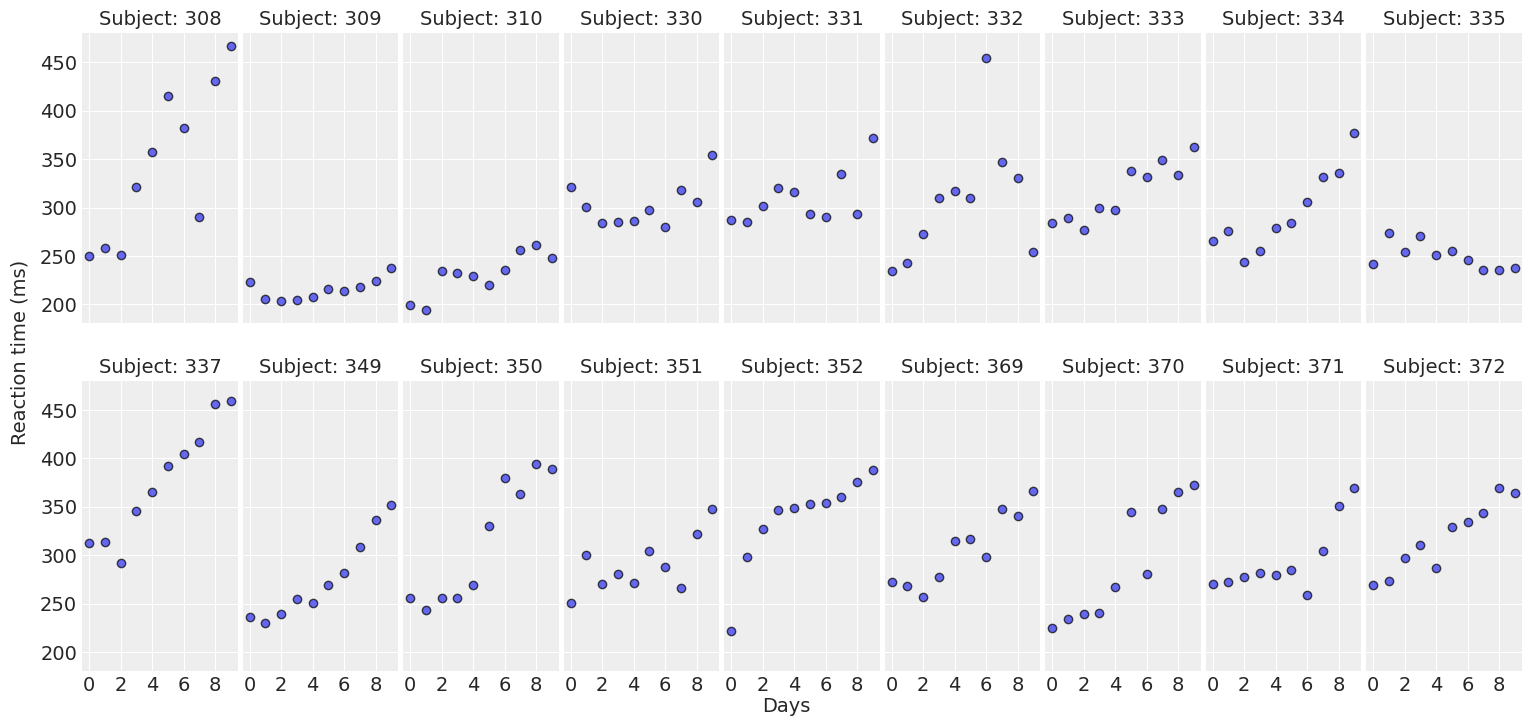

In [7]:
#| warning: false
plot_data(data);

For most of the subjects, there's a clear positive association between Days and Reaction time. **Reaction times increase as people accumulate more days of sleep deprivation**. Participants differ in the initial reaction times as well as in the association between sleep deprivation and reaction time. Reaction times increase faster for some subjects and slower for others. Finally, the relationship between Days and Reaction time presents some deviations from linearity within the panels, but these are neither substantial nor systematic.

## The model

The model we're going to build today is a hierarchical linear regression, with a Gaussian likelihood. In the following description, I use the greek letter $\beta$ to refer to common effects and the roman letter $u$ to refer to group-specific (or varying) effects.

$$
y_{ij} = \beta_0 + u_{0j} + \left( \beta_1 + u_{1j} \right) \cdot {\text{Days}} + \epsilon_i
$$

where

$$
\begin{aligned}
y_{ij} &= \text{Reaction time for the subject } j \text{ on day } i \\
\beta_0 &= \text{Intercept common to all subjects} \\ 
\beta_1 &= \text{Days slope common to all subjects} \\
u_{0j} &= \text{Intercept deviation of the subject } j \\
u_{1j} &= \text{Days slope deviation of the subject } j \\
\epsilon_i &= \text{Residual random error}
\end{aligned}
$$

we also have

$$
\begin{aligned}
i = 1, \cdots, 10 \\
j = 1, \cdots, 18 
\end{aligned}
$$

where $i$ indexes Days and $j$ indexes subjects.

From the mathematical description we notice both the intercept and the slope are made of two components. The intercept is made of a common or global intercept $\beta_0$ and subject-specific deviations $u_{0j}$. The same logic applies for the slope with both $\beta_1$ and $u_{1j}$.

## Priors

### Common effects

For the common effects, we Guassian independent priors.

$$
\begin{array}{c}
\beta_0 \sim \text{Normal}\left(\bar{y}, \sigma_{\beta_0}\right) \\
\beta_1 \sim \text{Normal}\left(0, \sigma_{\beta_1}\right) 
\end{array}
$$

[Bambi](https://github.com/bambinos/bambi) centers the prior for the intercept at $\bar{y}$, so do we. For $\sigma_{\beta_0}$ and $\sigma_{\beta_1}$ I'm going to use 50 and 10 respectively. We'll use these same priors for all the variants of the model above.

### Residual error

$$
\begin{aligned}
\epsilon_i &\sim \text{Normal}(0, \sigma) \\
\sigma &\sim \text{HalfStudentT}(\nu, \sigma_\epsilon)
\end{aligned}
$$

Where $\nu$ and $\sigma_\epsilon$, both positive constants, represent the degrees of freedom and the scale parameter, respectively.


### Group-specific effects

Throughout this post we'll propose the following variants for the priors of the group-specific effects.

* Independent priors.
* Correlated priors.
    + Using `LKJCholeskyCov`.
    + Using `LKJCorr`.
    + Usign `LKJCorr` with non-trivial standard deviation.

Each of them will be described in more detail in its own section.

Then we create `subjects` and `subjects_idx`. These represent the subject IDs and their indexes. These are used with the distribution of the group-specific coefficients. We also have the `coords` that we pass to the model and the mean of the prior for the intercept

In [8]:
# Subjects and subjects index
subjects, subjects_idx = np.unique(data["Subject"], return_inverse=True)

# Coordinates to handle dimensions of PyMC distributions and use better labels
coords = {"subject": subjects}

# Response mean -- Used in the prior for the intercept
y_mean = data["Reaction"].mean()

# Days variable
days = data["Days"].values

## Model 1: Independent priors

### Group-specific effects: Independent priors

$$
\begin{array}{lr}
u_{0j} \sim \text{Normal} \left(0, \sigma_{u_0}\right) & \text{for all } j:1,..., 18 \\
u_{1j} \sim \text{Normal} \left(0, \sigma_{u_1}\right) & \text{for all } j:1,..., 18
\end{array}
$$

where the hyperpriors are 

$$
\begin{array}{c}
\sigma_{u_0} \sim \text{HalfNormal} \left(\tau_0\right) \\
\sigma_{u_1} \sim \text{HalfNormal} \left(\tau_1\right) 
\end{array}
$$

where $\tau_0$ and $\tau_1$ represent the standard deviations of the hyperpriors. These are fixed positive constants. We set them to the same values than $\sigma_{\beta_0}$ and $\sigma_{\beta_1}$ respectively.

In [9]:
with pm.Model(coords=coords) as model_independent:
    # Common effects
    β0 = pm.Normal("β0", mu=y_mean, sigma=50)
    β1 = pm.Normal("β1", mu=0, sigma=10)
    
    # Group-specific effects
    # Intercept
    σ_u0 = pm.HalfNormal("σ_u0", sigma=50)
    u0 = pm.Normal("u0", mu=0, sigma=σ_u0, dims="subject")
    
    # Slope
    σ_u1 = pm.HalfNormal("σ_u1", sigma=10)   
    u1 = pm.Normal("u1", mu=0, sigma=σ_u1, dims="subject")
   
    # Construct intercept and slope
    intercept = pm.Deterministic("intercept", β0 + u0[subjects_idx]) 
    slope = pm.Deterministic("slope", (β1 + u1[subjects_idx]) * days) 
    
    # Conditional mean
    μ = pm.Deterministic("μ", intercept + slope)
    
    # Residual standard deviation
    σ = pm.HalfStudentT("σ", nu=4, sigma=50)
    
    # Response
    y = pm.Normal("y", mu=μ, sigma=σ, observed=data["Reaction"])

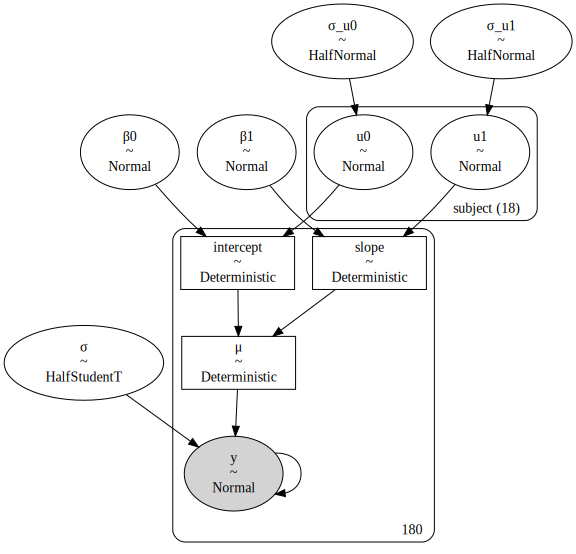

In [10]:
pm.model_to_graphviz(model_independent)

In [11]:
with model_independent:
    idata_independent = pm.sample(draws=1000, chains=4, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [β0, β1, σ_u0, u0, σ_u1, u1, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


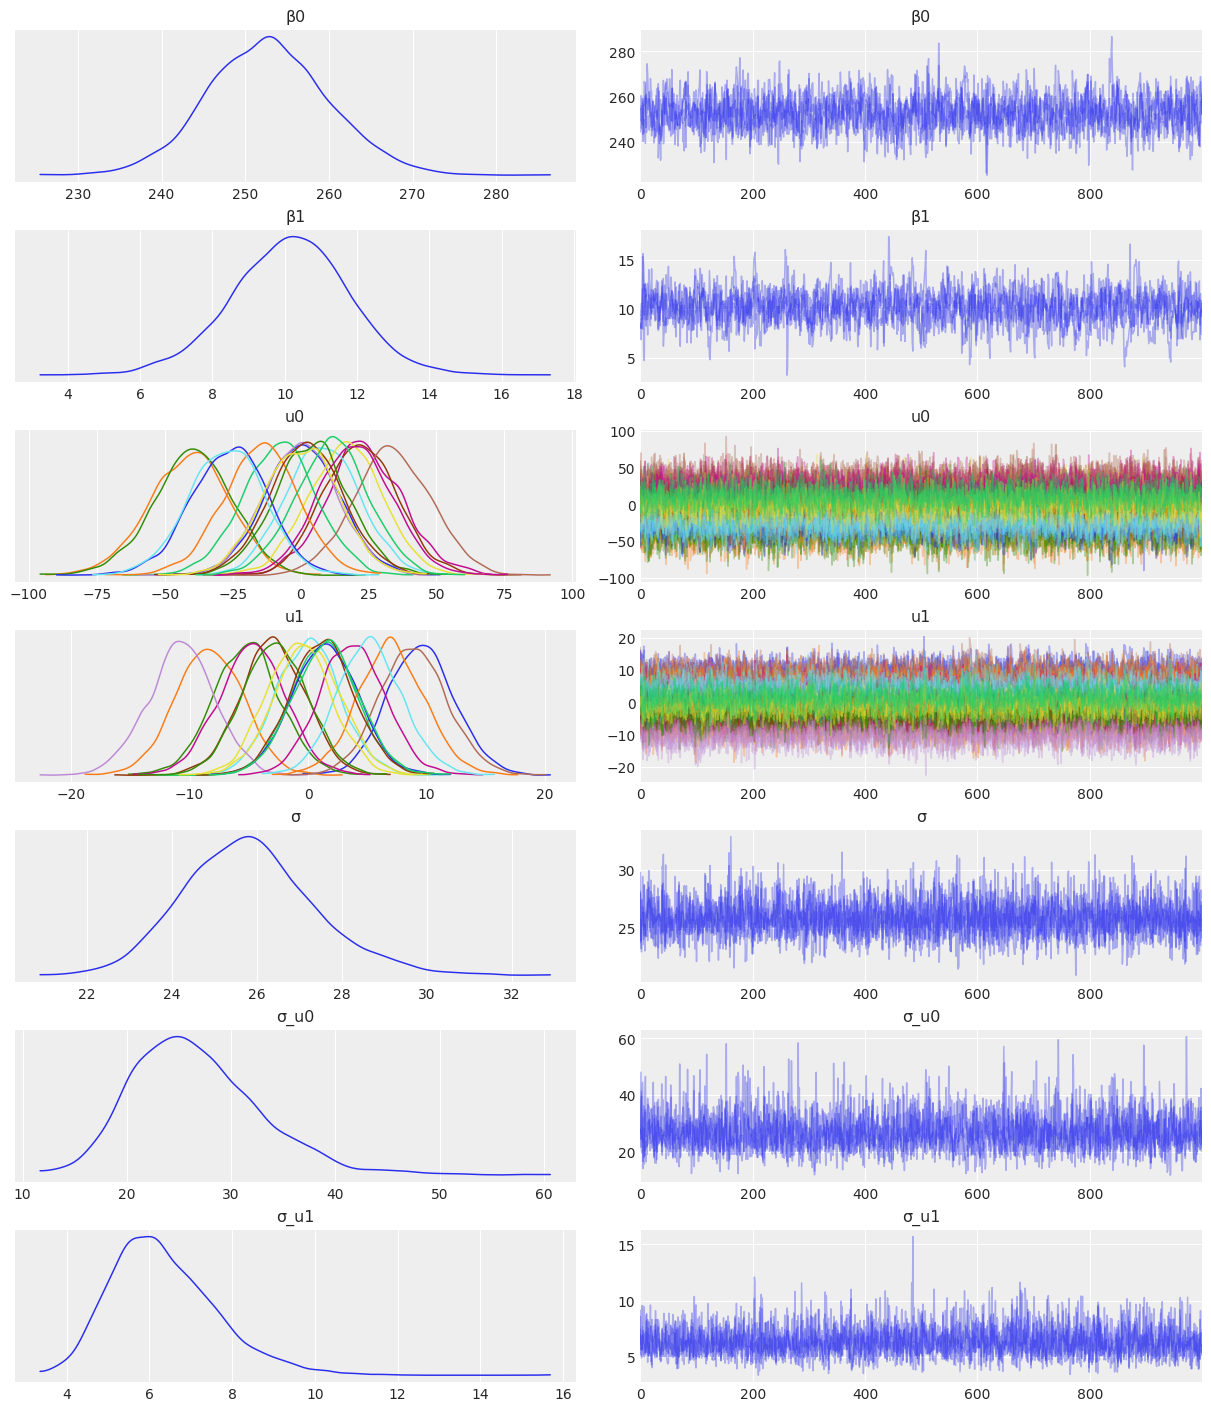

In [12]:
az.plot_trace(
    idata_independent, 
    var_names=["β0", "β1", "u0", "u1", "σ", "σ_u0", "σ_u1"],
    combined=True, 
    chain_prop={"ls": "-"}
);

In [13]:
def plot_predictions(data, idata, figsize=(16, 7.5)):
    # Plot the data
    fig, axes = plot_data(data, figsize=figsize)
    
    # Extract predicted mean
    reaction_mean = idata.posterior["μ"]

    for subject, ax in zip(subjects, axes.ravel()):
        idx = (data["Subject"]== subject).values
        days = data.loc[idx, "Days"].values

        # Plot highest density interval / credibility interval
        az.plot_hdi(days, reaction_mean[..., idx], color="C0", ax=ax)

        # Plot mean regression line
        ax.plot(days, reaction_mean[..., idx].mean(("chain", "draw")), color="C0")
    
    return fig ,axes

/tmp/ipykernel_30944/3738382015.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)


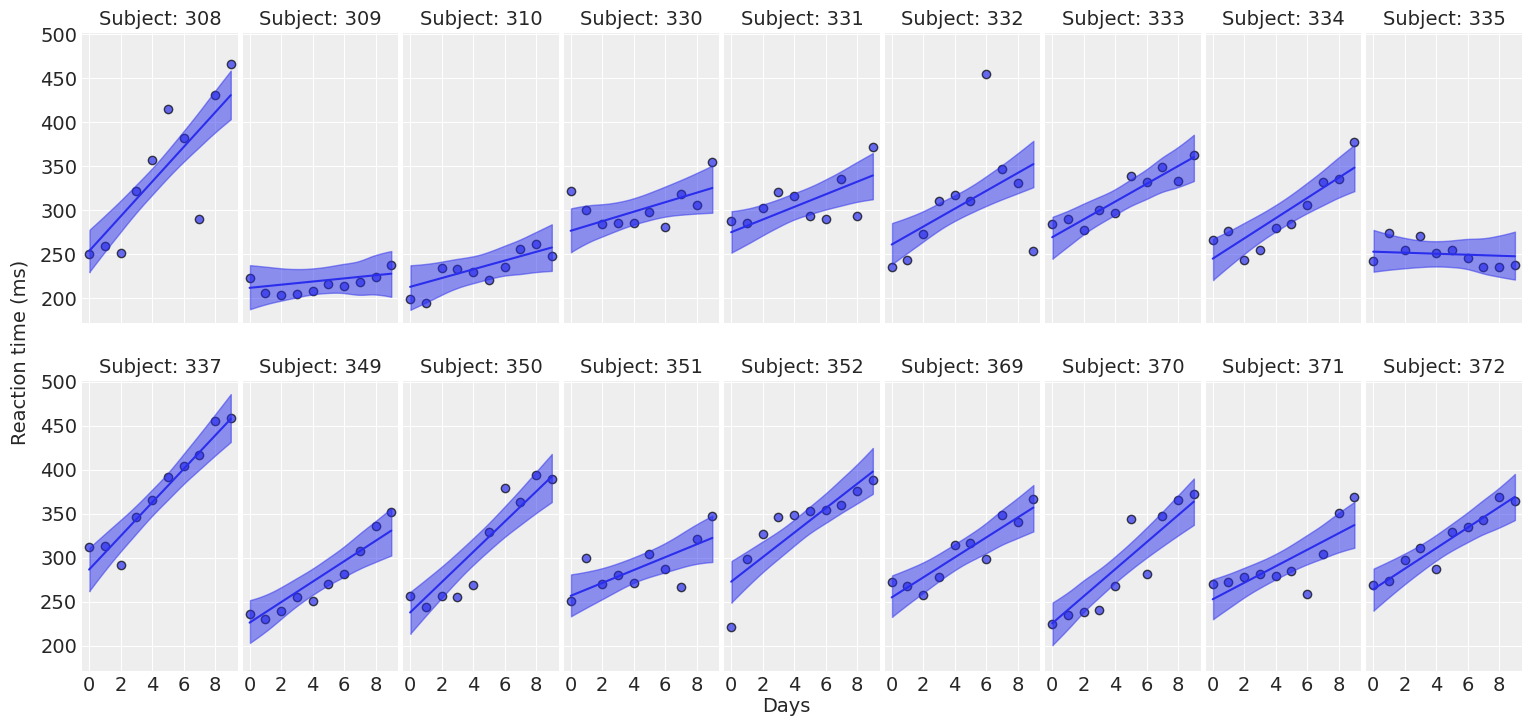

In [14]:
#| warning: false
plot_predictions(data, idata_independent);

## Correlated priors

Instead of placing independent priors on $u_{0j}$ and $u_{1j}$, we place a multivariate normal prior on $[u_{0j}, u_{1j}]^T$, which allows for correlated group-specific effects.

$$
\begin{array}{lr}
    \left[ 
        \begin{array}{c} 
            u_{0j} \\ 
            u_{0j} 
        \end{array}
    \right]
    \sim \text{MvNormal}
    \left(
        \left[ 
            \begin{array}{c} 
                0 \\ 
                0 
            \end{array}
        \right],
        \Sigma = 
        \left[
            \begin{array}{cc}
                \sigma_{u_0}^2 & \text{cov}(u_0, u_1) \\
                \text{cov}(u_0, u_1) & \sigma_{u_1}^2
            \end{array}
        \right]
    \right)
    &
    \text{for all } j:1,..., 18
\end{array}
$$

and we use the same hyperpriors

$$
\begin{array}{c}
\sigma_{u_0} \sim \text{HalfNormal} \left(\tau_0\right) \\
\sigma_{u_1} \sim \text{HalfNormal} \left(\tau_1\right) 
\end{array}
$$

### Prior on correlation matrices

In practice, we do not set a prior for the covariance matrix $\Sigma$. Instead, we set a prior on the correlation matrix $\Omega$ and use the following decomposition to recover the covariance matrix

$$
\begin{split}
    \Sigma & = 
    \begin{pmatrix}
        \sigma_{u_0} & 0 \\
        0 & \sigma_{u_1}
    \end{pmatrix}
    \begin{pmatrix} 1 & \rho_{u_0, u_1} \\ \rho_{u_0, u_1} & 1 \end{pmatrix} 
    \begin{pmatrix}
        \sigma_{u_0} & 0 \\
        0 & \sigma_{u_1}
    \end{pmatrix} \\
      & = \text{diag}(\sigma_u) \ \Omega \ \text{diag}(\sigma_u) 
\end{split}
$$

A very popular and flexible alternative is to place an LKJ prior on the correlation matrix. 

$$
\Omega \sim \text{LKJ}(\eta), \ \  \eta > 0
$$


LKJ stands for the [Lewandowski-Kurowicka-Joe distribution](https://en.wikipedia.org/wiki/Lewandowski-Kurowicka-Joe_distribution). If $\eta = 1$ (our default choice), the prior is jointly uniform over all correlation matrices of the same dimension as $\Omega$. If $\eta > 1$, then the mode of the distribution is the identity matrix. The larger the value of $\eta$ the more sharply peaked the density is at the identity matrix


### Cholesky decomposition

For efficiency and numerical stability, the correlation matrix $\Omega$ can be parametrized by its (lower-triangular) Cholesky factor $L$, which can be seen as the square root of $\Omega$

$$
\boldsymbol{L}\boldsymbol{L^T} = \Omega = \begin{pmatrix} 1 & \rho_{u_0, u_1} \\ \rho_{u_0, u_1} & 1 \end{pmatrix} 
$$

If $\boldsymbol{Z}_{\text{uncorr}}$ is a $2\times n$ matrix where the rows are 2 samples from uncorrelated random variables, then

$$
\begin{split}
    \boldsymbol{Z}_{\text{corr}} & =
    \begin{pmatrix} \sigma_{u_0} & 0 \\ 0 & \sigma_{u_1} \end{pmatrix} 
    \boldsymbol{L}
    \boldsymbol{Z}_{\text{uncorr}} \\
    & = \text{diag}(\sigma_u) \boldsymbol{L} \boldsymbol{Z}_{\text{uncorr}}     
\end{split}
$$


Then $\boldsymbol{Z}_{\text{corr}}$, of shape $(2, n)$, contains a sample of size $n$ of two correlated variables with the desired variances $\sigma_{u_0}^2$, $\sigma_{u_1}^2$, and correlation $\rho_{u_0, u_1}$.

## Model 2: Correlated priors with `LKJCholeskyCov`

PyMC conveniently implements a distribution called `LKJCholeskyCov`. Here, `n` represents the dimension of the correlation matrix. `eta` is the parameter of the LKJ distribution. `sd_dist` is the prior distribution for the standard deviations of the group-specific effects. `compute_corr=True` means we want it to also return the correlation between the group-specific parameters and their standard deviations. `store_in_trace=False` means we don't want to store the correlation and the standard deviations in the trace.

Before seeing the code, we note that `sd_dist` is not a random variable, but a stateless distribution (i.e. the result of `pm.Distribution.dist()`).

In [15]:
coords.update({"effect": ["intercept", "slope"]})

with pm.Model(coords=coords) as model_lkj_cov:
    ## Common effects
    β0 = pm.Normal("β0", mu=y_mean, sigma=50)
    β1 = pm.Normal("β1", mu=0, sigma=10)
   
    ## Group-specific effects
    # Hyper prior for the standard deviations
    u_σ = pm.HalfNormal.dist(sigma=np.array([50, 10]), shape=2)
    
    # Obtain Cholesky factor for the covariance
    L, ρ_u, σ_u = pm.LKJCholeskyCov(
        "L", n=2, eta=1, sd_dist=u_σ, compute_corr=True, store_in_trace=False
    )
    
    # Parameters
    u_raw = pm.Normal("u_raw", mu=0, sigma=1, dims=("effect", "subject")) 
    u = pm.Deterministic("u", at.dot(L, u_raw).T, dims=("subject", "effect"))
   
    ## Separate group-specific terms 
    # Intercept
    u0 = pm.Deterministic("u0", u[:, 0], dims="subject")
    σ_u0 = pm.Deterministic("σ_u0", σ_u[0])
    
    # Slope
    u1 = pm.Deterministic("u1", u[:, 1], dims="subject")
    σ_u1 = pm.Deterministic("σ_u1", σ_u[1])

    # Correlation
    ρ_u = pm.Deterministic("ρ_u", ρ_u[0, 1])
    
    # Construct intercept and slope
    intercept = pm.Deterministic("intercept", β0 + u0[subjects_idx]) 
    slope = pm.Deterministic("slope", (β1 + u1[subjects_idx]) * days) 
    
    # Conditional mean
    μ = pm.Deterministic("μ", intercept + slope)
    
    ## Residual standard deviation
    σ = pm.HalfStudentT("σ", nu=4, sigma=56)
    
    ## Response
    y = pm.Normal("y", mu=μ, sigma=σ, observed=data["Reaction"])

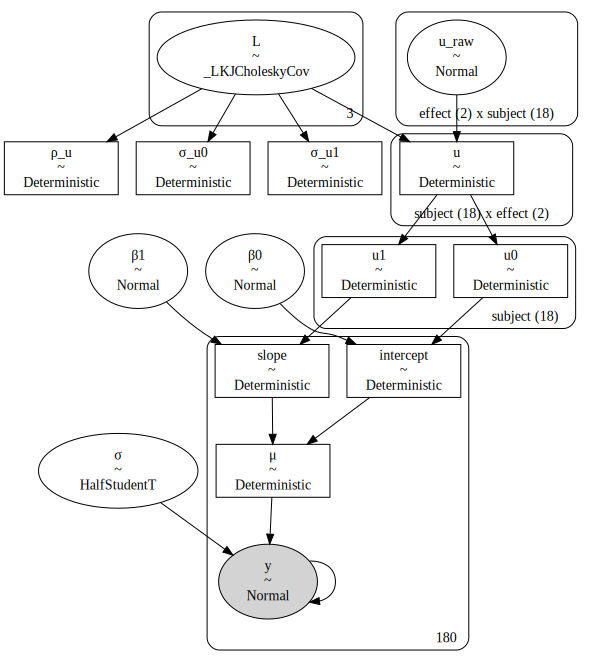

In [16]:
pm.model_to_graphviz(model_lkj_cov)

In [17]:
with model_lkj_cov:
    idata_lkj_cov = pm.sample(draws=1000, chains=4, random_seed=1234, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [β0, β1, L, u_raw, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.


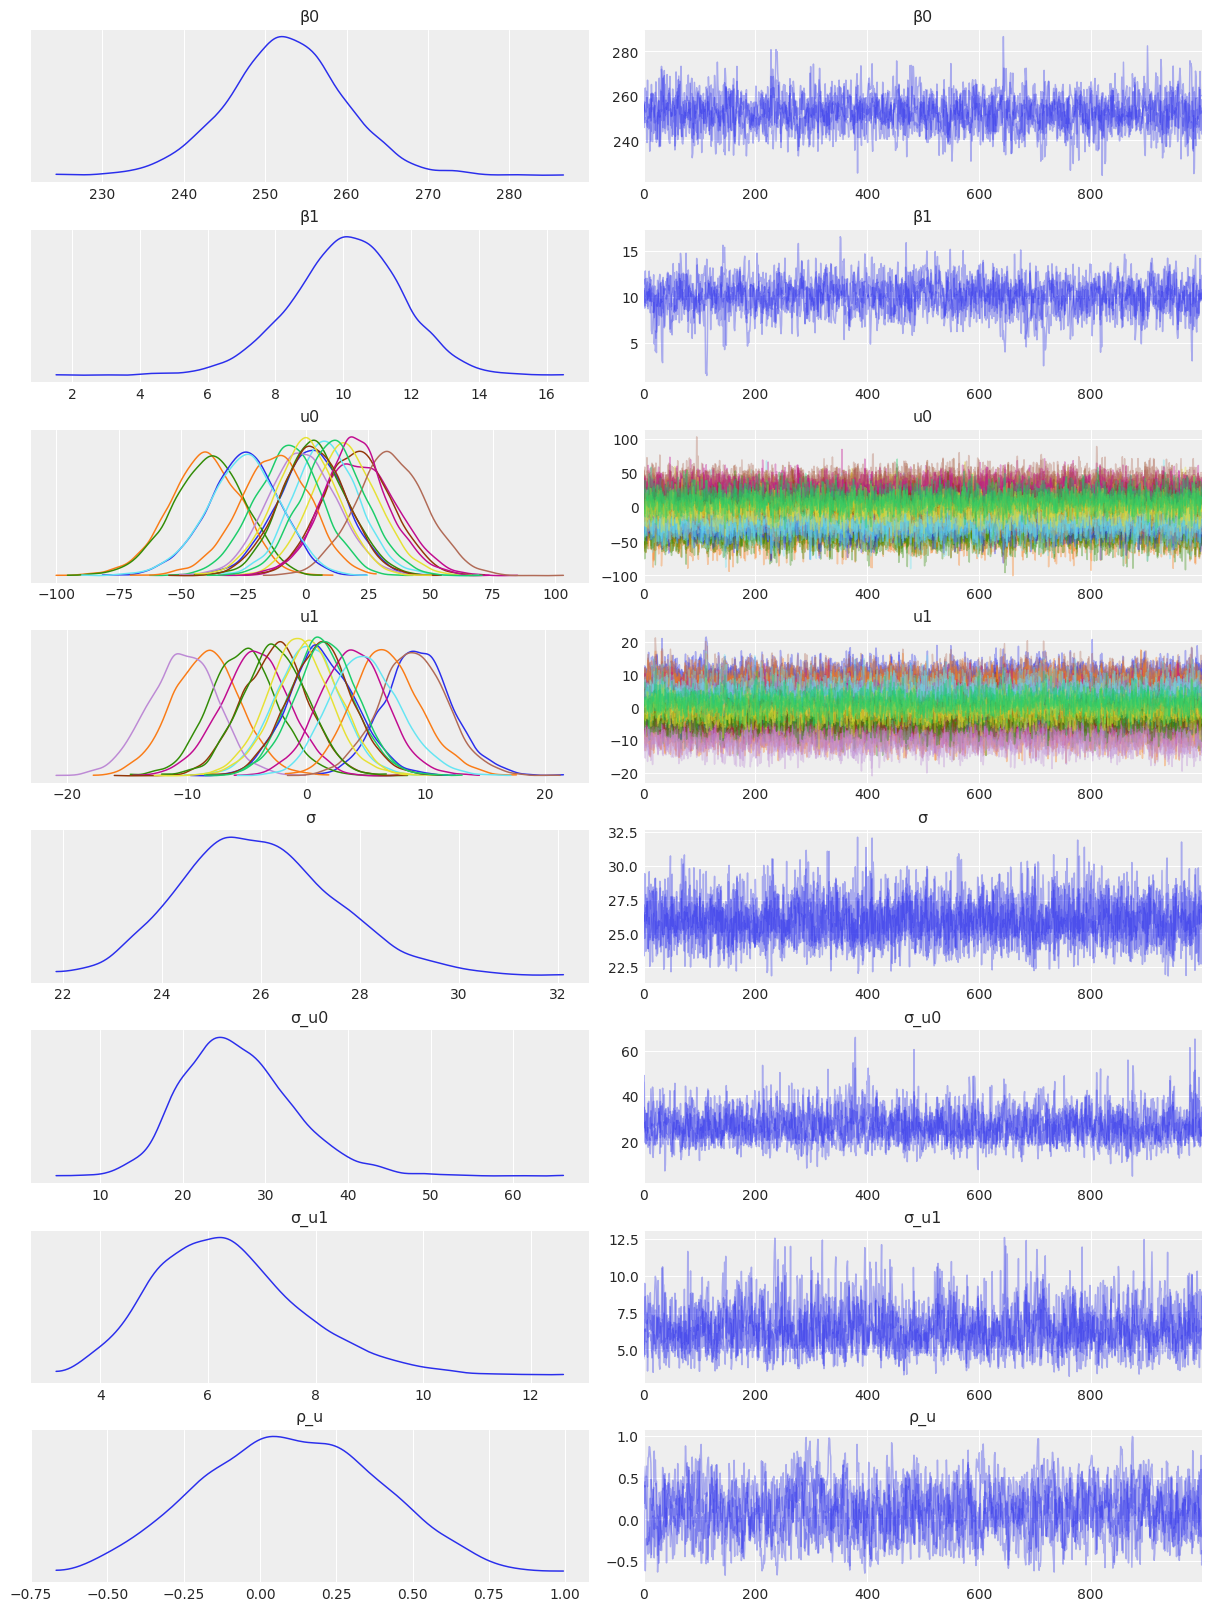

In [18]:
az.plot_trace(
    idata_lkj_cov, 
    var_names=["β0", "β1", "u0", "u1", "σ", "σ_u0", "σ_u1", "ρ_u"],
    combined=True, 
    chain_prop={"ls": "-"}
);

From the traceplot of the correlation coefficient `ρ_u` it looks like the group-specific intercept and slope are not related since the distribution is centered around zero.

But there's another question we haven't answered yet: Are the initial reaction times associated with how much the sleep deprivation affects the evolution of reaction times? Let's create a scatterplot to visualize the joint posterior of the subject-specific intercepts and slopes. This chart uses different colors for the individuals.

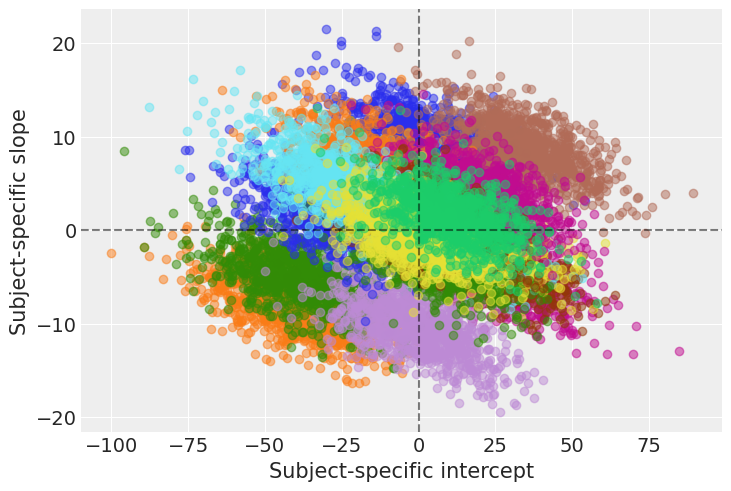

In [19]:
posterior_u0 = idata_lkj_cov.posterior["u0"].values
posterior_u1 = idata_lkj_cov.posterior["u1"].values

fig, ax = plt.subplots()
for subject in range(18):
    # Not all the samples are drawn
    x = posterior_u0[::10, :, subject]
    y = posterior_u1[::10, :, subject]
    ax.scatter(x, y, alpha=0.5)
    
ax.axhline(c="k", ls="--", alpha=0.5)
ax.axvline(c="k", ls="--", alpha=0.5)
ax.set(xlabel="Subject-specific intercept", ylabel="Subject-specific slope");

If we look at the bigger picture, i.e omitting the groups, we can conclude there's no association between the intercept and slope. In other words, having lower or higher intial reaction times does not say anything about how much sleep deprivation affects the average reaction time on a given subject.

On the other hand, if we look at the joint posterior for a given individual, we can see a negative correlation between the intercept and the slope. This is telling that, conditional on a given subject, the intercept and slope posteriors are not independent. However, it doesn't imply anything about the overall relationship between the intercept and the slope, which is what we need if we want to know whether the initial time is associated with how much sleep deprivation affects the reaction time.

Let's check predictions

/tmp/ipykernel_30944/3738382015.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)


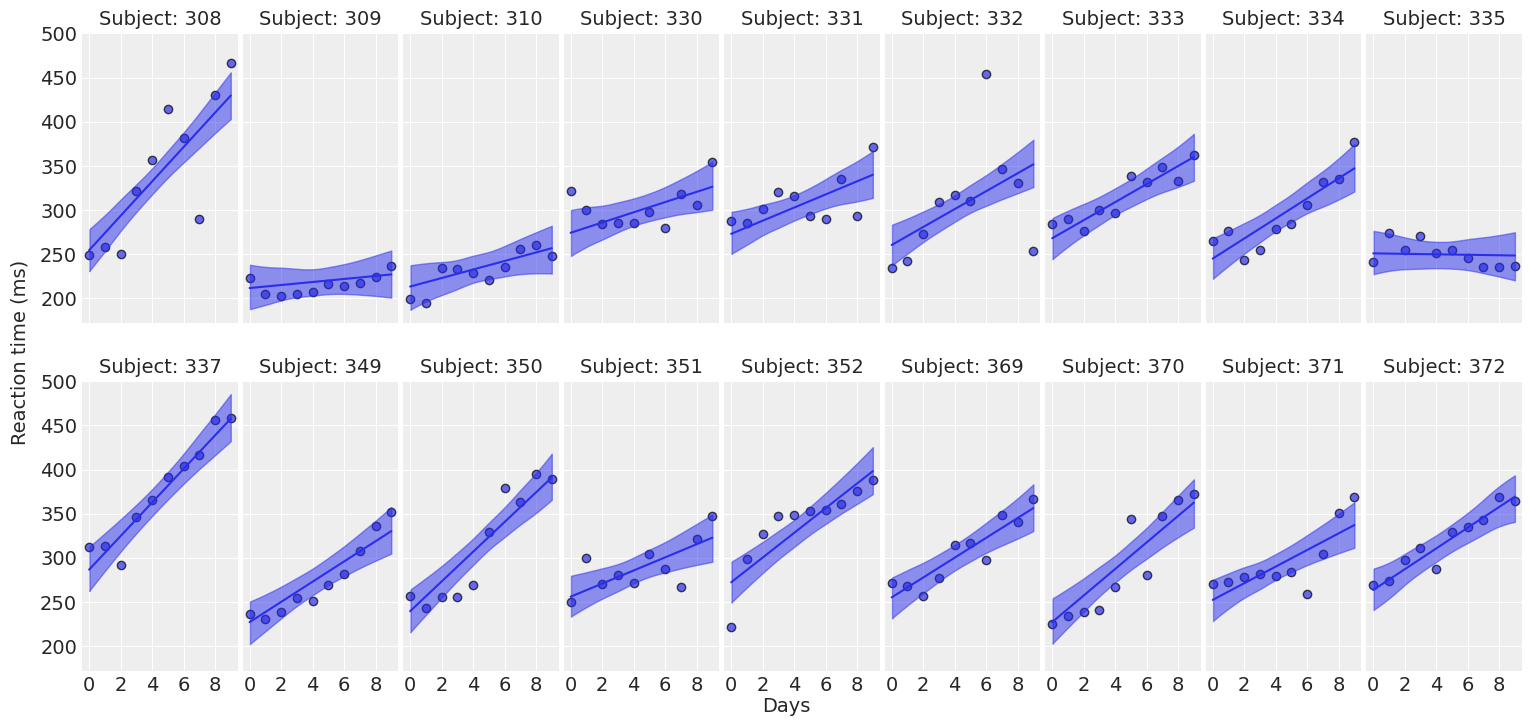

In [20]:
#| warning: false
plot_predictions(data, idata_lkj_cov);

## Model 3: Correlated priors with `LKJCorr`.

One problem with `LKJCholeskyCov` is that its `sd_dist` argument must be a stateless distribution and thus **we cannot use a customized distribution for the standard deviations of the group-specific effects**.

If we want to use a random variable instead of a stateless distribution for the standard deviation of the group-specific effects, then we need to perform many steps manually. Let's see how we can implement it!

In [21]:
with pm.Model(coords=coords) as model_lkj_corr:
    # Common part
    β0 = pm.Normal("β0", mu=y_mean, sigma=50)
    β1 = pm.Normal("β1", mu=0, sigma=10)
    
    # Group-specific part   
    σ_u = pm.HalfNormal("u_σ", sigma=np.array([50, 10]), dims="effect")
    
    # Triangular upper part of the correlation matrix
    Ω_triu = pm.LKJCorr("Ω_triu", eta=1, n=2)

    # Construct correlation matrix
    Ω = pm.Deterministic(
        "Ω", 
        at.fill_diagonal(Ω_triu[np.zeros((2, 2), dtype=np.int64)], 1)
    )
    
    # Construct diagonal matrix of standard deviation
    σ_diagonal = pm.Deterministic("σ_diagonal", at.eye(2) * σ_u)
    
    # Compute covariance matrix
    Σ = at.nlinalg.matrix_dot(σ_diagonal, Ω, σ_diagonal)
    
    # Cholesky decomposition of covariance matrix
    L = pm.Deterministic("L", at.slinalg.cholesky(Σ))
    
    # And finally get group-specific coefficients
    u_raw = pm.Normal("u_raw", mu=0, sigma=1, dims=("effect", "subject")) 
    u = pm.Deterministic("u", at.dot(L, u_raw).T, dims=("subject", "effect"))

    u0 = pm.Deterministic("u0", u[:, 0], dims="subject")
    σ_u0 = pm.Deterministic("σ_u0", σ_u[0])
    
    u1 = pm.Deterministic("u1", u[:, 1], dims="subject")
    σ_u1 = pm.Deterministic("σ_u1", σ_u[1])
    
    # Correlation
    ρ_u = pm.Deterministic("ρ_u", Ω[0, 1])
         
    # Construct intercept and slope
    intercept = pm.Deterministic("intercept", β0 + u0[subjects_idx]) 
    slope = pm.Deterministic("slope", (β1 + u1[subjects_idx]) * days) 
    
    # Conditional mean
    μ = pm.Deterministic("μ", intercept + slope)
    
    σ = pm.HalfStudentT("σ", nu=4, sigma=50)
    y = pm.Normal("y", mu=μ, sigma=σ, observed=data["Reaction"])

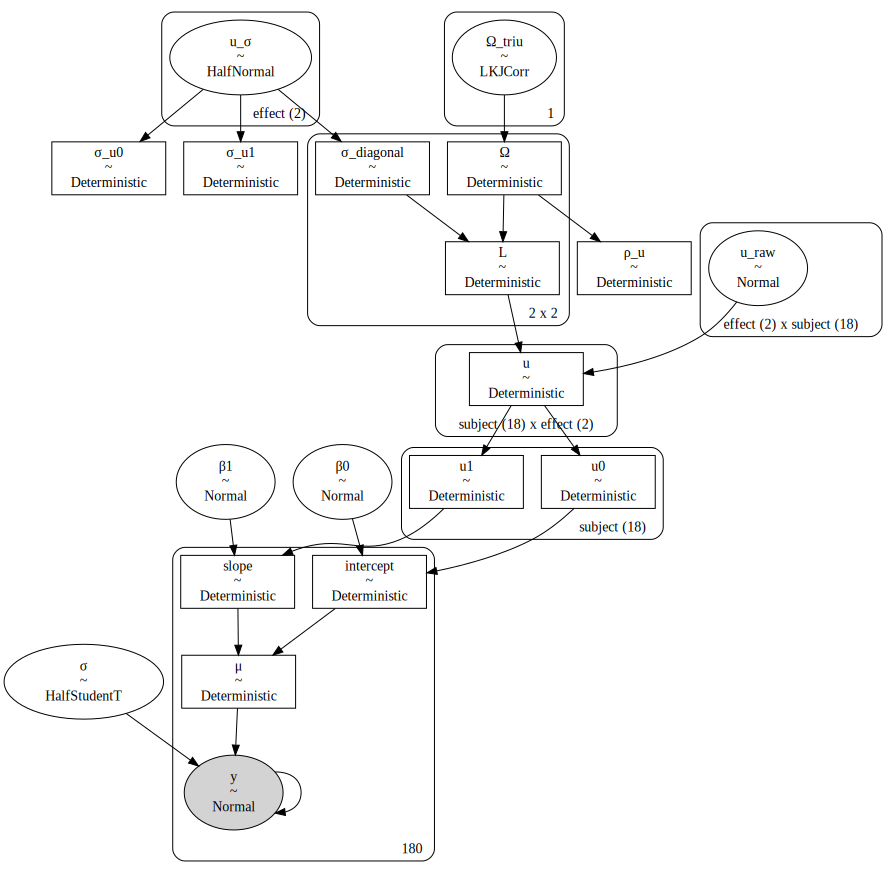

In [22]:
pm.model_to_graphviz(model_lkj_corr)

In [23]:
with model_lkj_corr:
    idata_lkj_corr = pm.sample(draws=1000, chains=2, random_seed=1234, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β0, β1, u_σ, Ω_triu, u_raw, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 76 seconds.


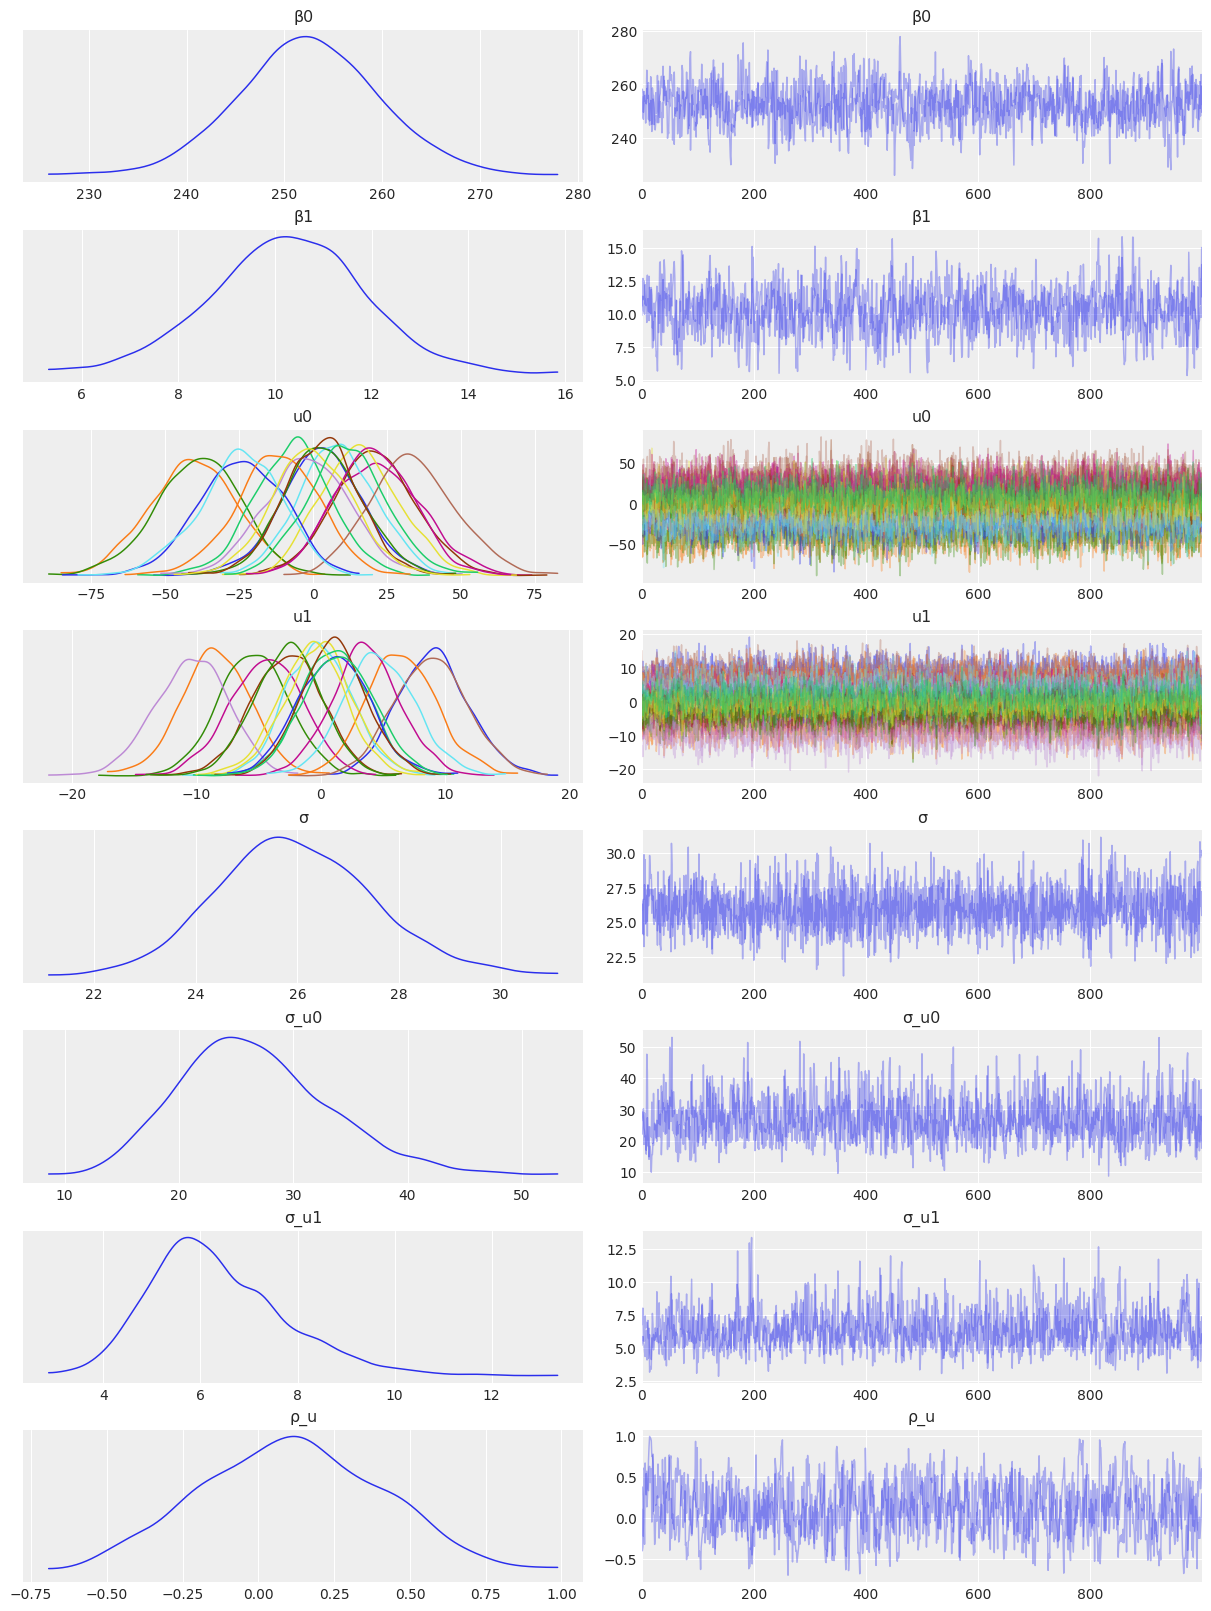

In [24]:
az.plot_trace(
    idata_lkj_corr, 
    var_names=["β0", "β1", "u0", "u1", "σ", "σ_u0", "σ_u1", "ρ_u"],
    combined=True, 
    chain_prop={"ls": "-"}
);

/tmp/ipykernel_30944/3738382015.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)


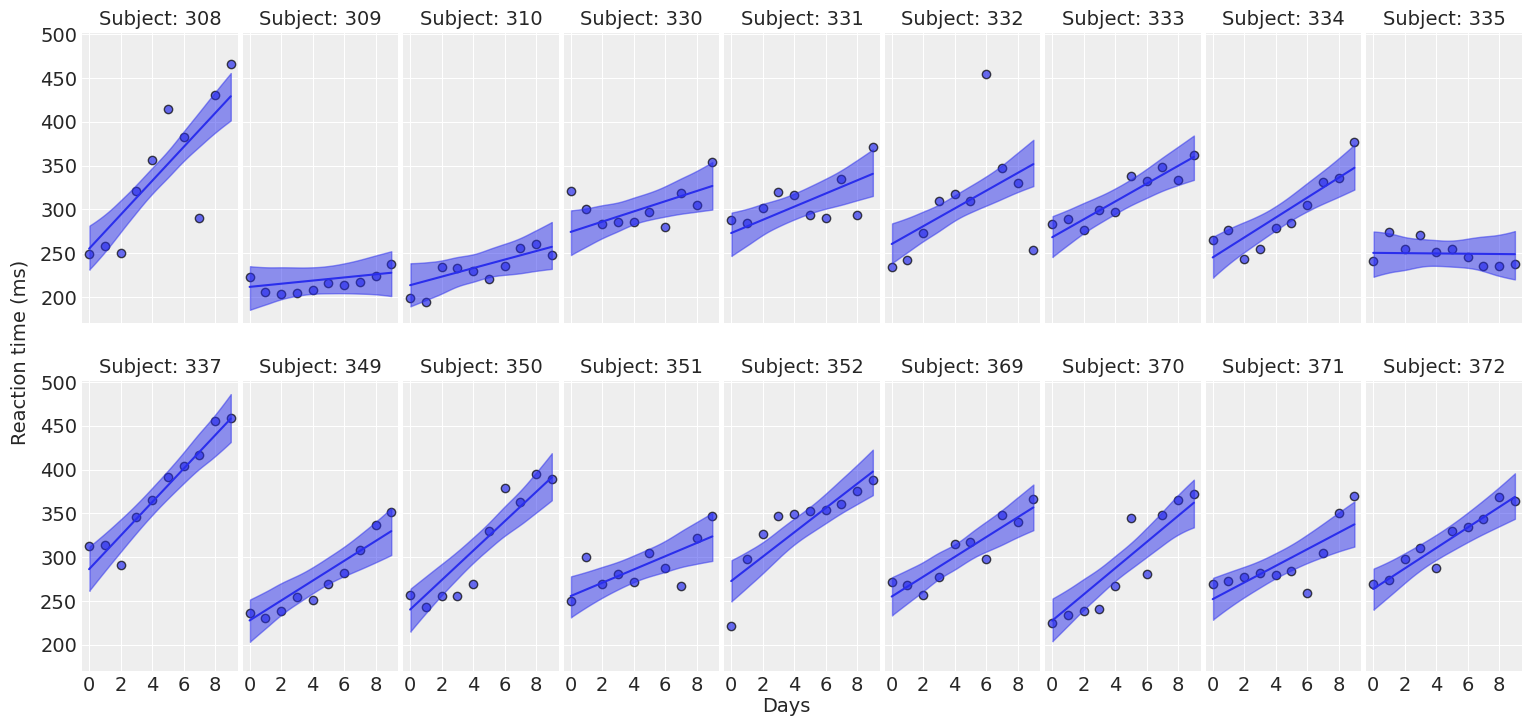

In [25]:
#| warning: false
plot_predictions(data, idata_lkj_corr);

## Model 4: Correlated priors with `LKJCorr`. Replicate rstanarm prior


This model is like the previous one, but `σ_u` is the result of multiplying several random variables. Rstanarm prior is introduced [here](http://mc-stan.org/rstanarm/articles/glmer.html)

**NOTE:** `σ_u` is what I would like to be able to pass to the `sd_dist` argument in `pm.LKJCholeskyCov`. Since I can only pass a stateless distribution, I need to perform all the steps manually.

> The vector of variances is set equal to the product of a simplex vector $\pi$ — which is non-negative and sums to 1 — and the scalar trace: $J\tau^2\pi$.  
>[...]  
> For the simplex vector $\pi$ we use a symmetric Dirichlet prior which has a single concentration parameter $\gamma > 0$.

On top of that, the $J\tau^2\pi$ is scaled by the residual standard deviation as explained in [this comment](https://github.com/stan-dev/rstanarm/issues/531#issuecomment-861875451).

In [26]:
J = 2 # Order of covariance matrix

with pm.Model(coords=coords) as model_lkj_corr_2:
    # Common part
    β0 = pm.Normal("β0", mu=y_mean, sigma=50)
    β1 = pm.Normal("β1", mu=0, sigma=10)
    
    # Residual SD 
    σ = pm.HalfStudentT("σ", nu=4, sigma=50)
    
    # Group-specific part
    # Begin of rstanarm approach ----------------------------------
    τ = pm.Gamma("τ", alpha=1, beta=1)
    Σ_trace = J * τ ** 2
    π = pm.Dirichlet("π", a=np.ones(J), dims="effect")
    σ_u = pm.Deterministic("b_σ", σ * π * (Σ_trace) ** 0.5)
    # End of rstanarm approach ------------------------------------
    
    # Triangular upper part of the correlation matrix
    Ω_triu = pm.LKJCorr("Ω_triu", eta=1, n=2)
     
    # Correlation matrix
    Ω = pm.Deterministic(
        "Ω", at.fill_diagonal(Ω_triu[np.zeros((2, 2), dtype=np.int64)], 1.)
    )

    # Construct diagonal matrix of standard deviation
    σ_u_diagonal = pm.Deterministic("σ_u_diagonal", at.eye(2) * σ_u)
    
    # Covariance matrix
    Σ = at.nlinalg.matrix_dot(σ_u_diagonal, Ω, σ_u_diagonal)
    
    # Cholesky decomposition, lower triangular matrix.
    L = pm.Deterministic("L", at.slinalg.cholesky(Σ))
    u_raw = pm.Normal("u_raw", mu=0, sigma=1, dims=("effect", "subject")) 
    
    u = pm.Deterministic("u", at.dot(L, u_raw).T, dims=("subject", "effect"))
                         
    u0 = pm.Deterministic("u0", u[:, 0], dims="subject")
    σ_u0 = pm.Deterministic("σ_u0", σ_u[0])
    
    u1 = pm.Deterministic("u1", u[:, 1], dims="subject")
    σ_u1 = pm.Deterministic("σ_u1", σ_u[1])
    
    # Correlation
    ρ_u = pm.Deterministic("ρ_u", Ω[0, 1])
         
    # Construct intercept and slope
    intercept = pm.Deterministic("intercept", β0 + u0[subjects_idx]) 
    slope = pm.Deterministic("slope", (β1 + u1[subjects_idx]) * days) 
    
    # Conditional mean
    μ = pm.Deterministic("μ", intercept + slope)
       
    y = pm.Normal("y", mu=μ, sigma=σ, observed=data["Reaction"])

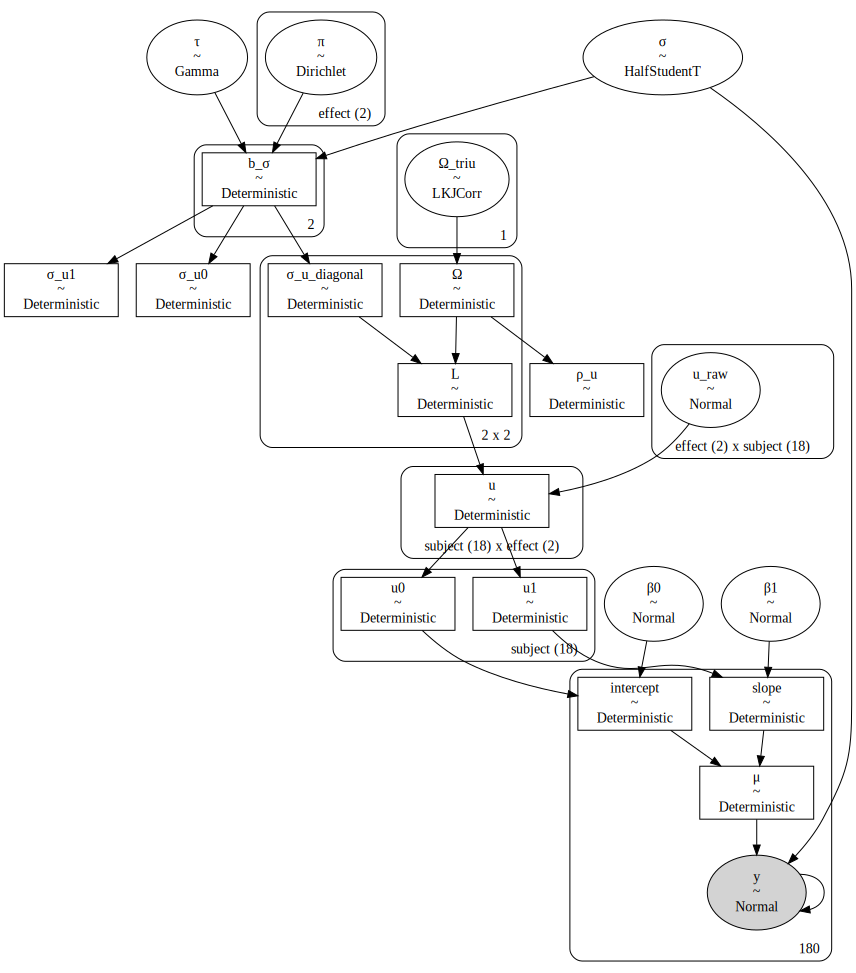

In [27]:
pm.model_to_graphviz(model_lkj_corr_2)

In [28]:
with model_lkj_corr_2:
    idata_lkj_corr_2 = pm.sample(draws=1000, chains=4, random_seed=1234, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [β0, β1, σ, τ, π, Ω_triu, u_raw]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 181 seconds.


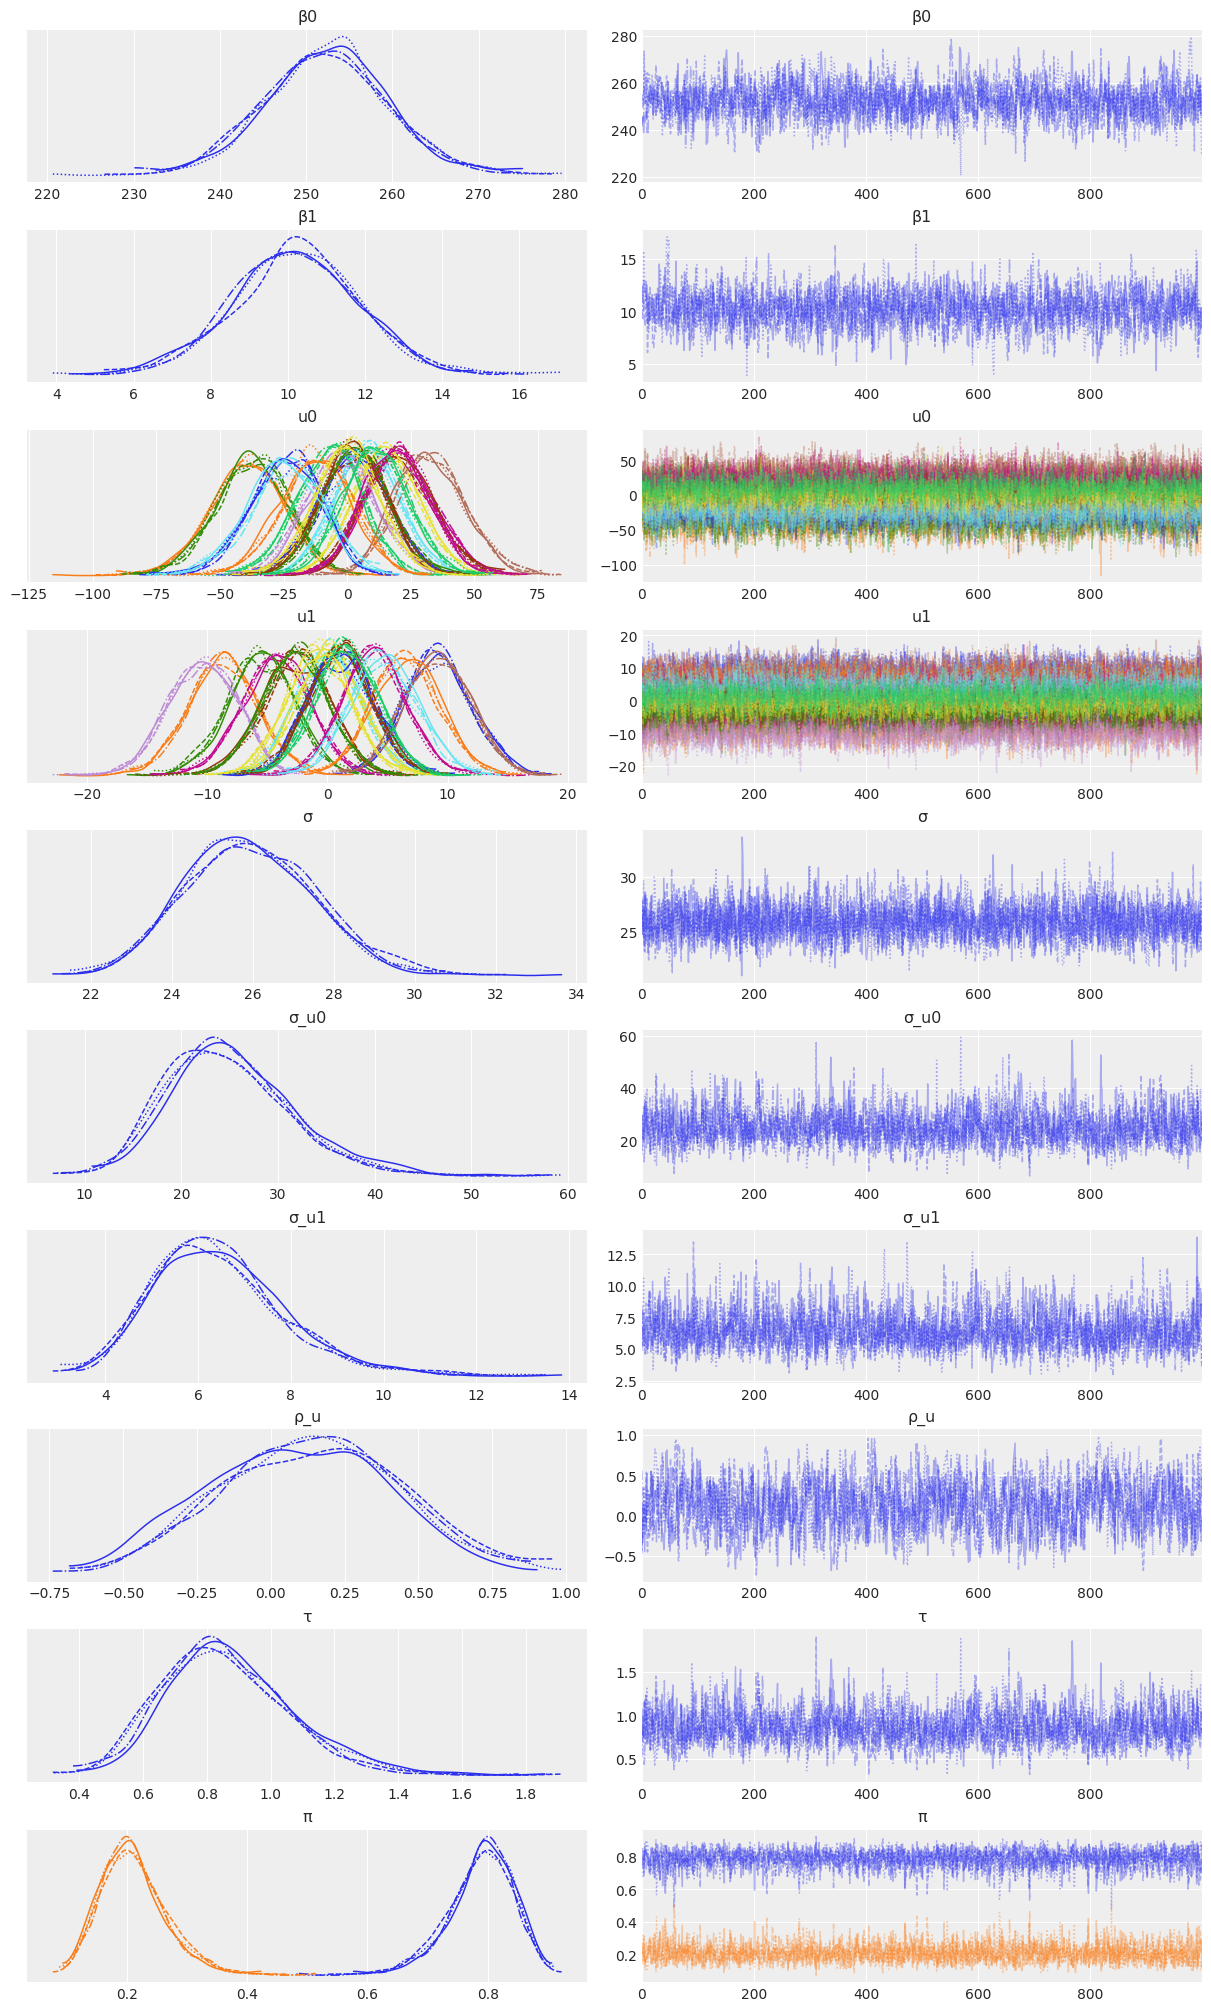

In [29]:
az.plot_trace(
    idata_lkj_corr_2,
    var_names=["β0", "β1", "u0", "u1", "σ", "σ_u0", "σ_u1", "ρ_u", "τ", "π"],
);

/tmp/ipykernel_30944/3738382015.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)


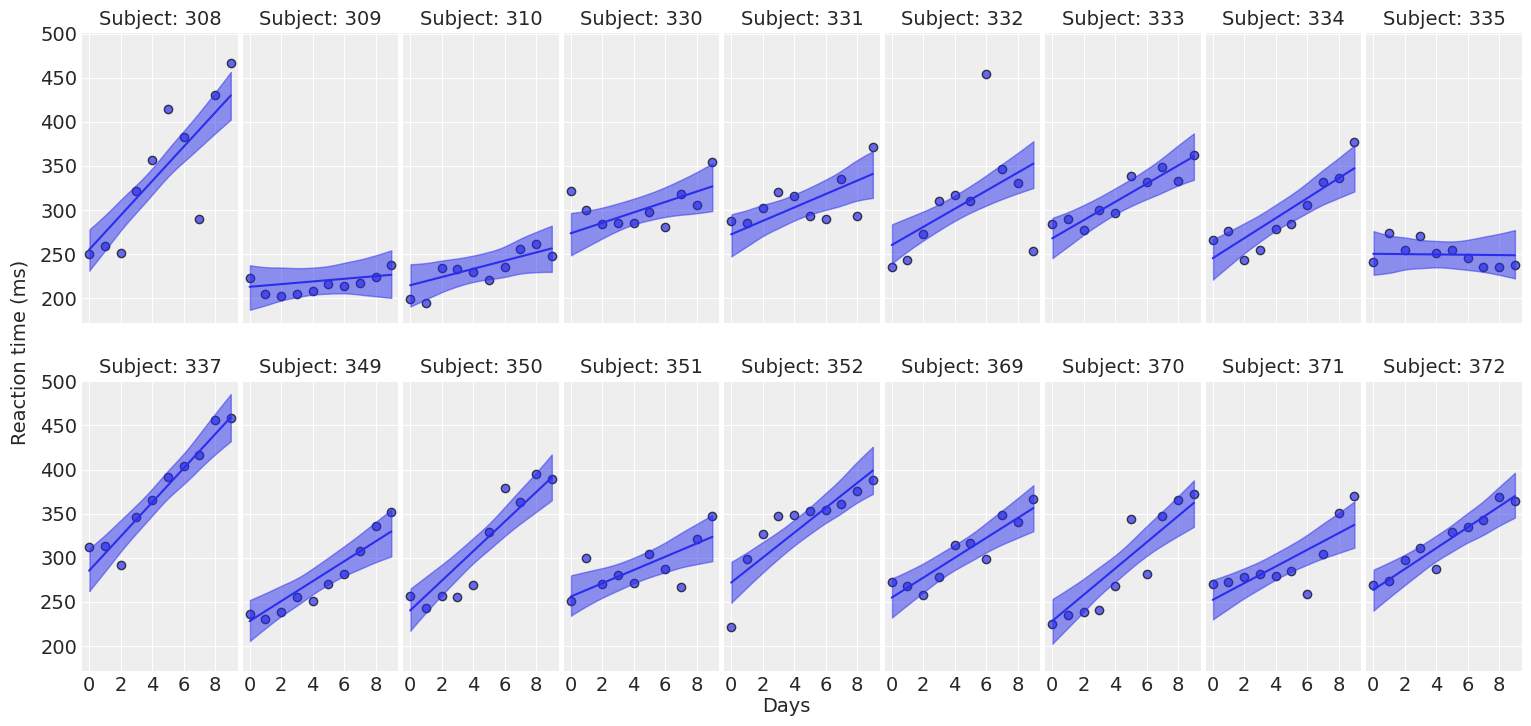

In [30]:
#| warning: false
plot_predictions(data, idata_lkj_corr_2);

## Compare inferences

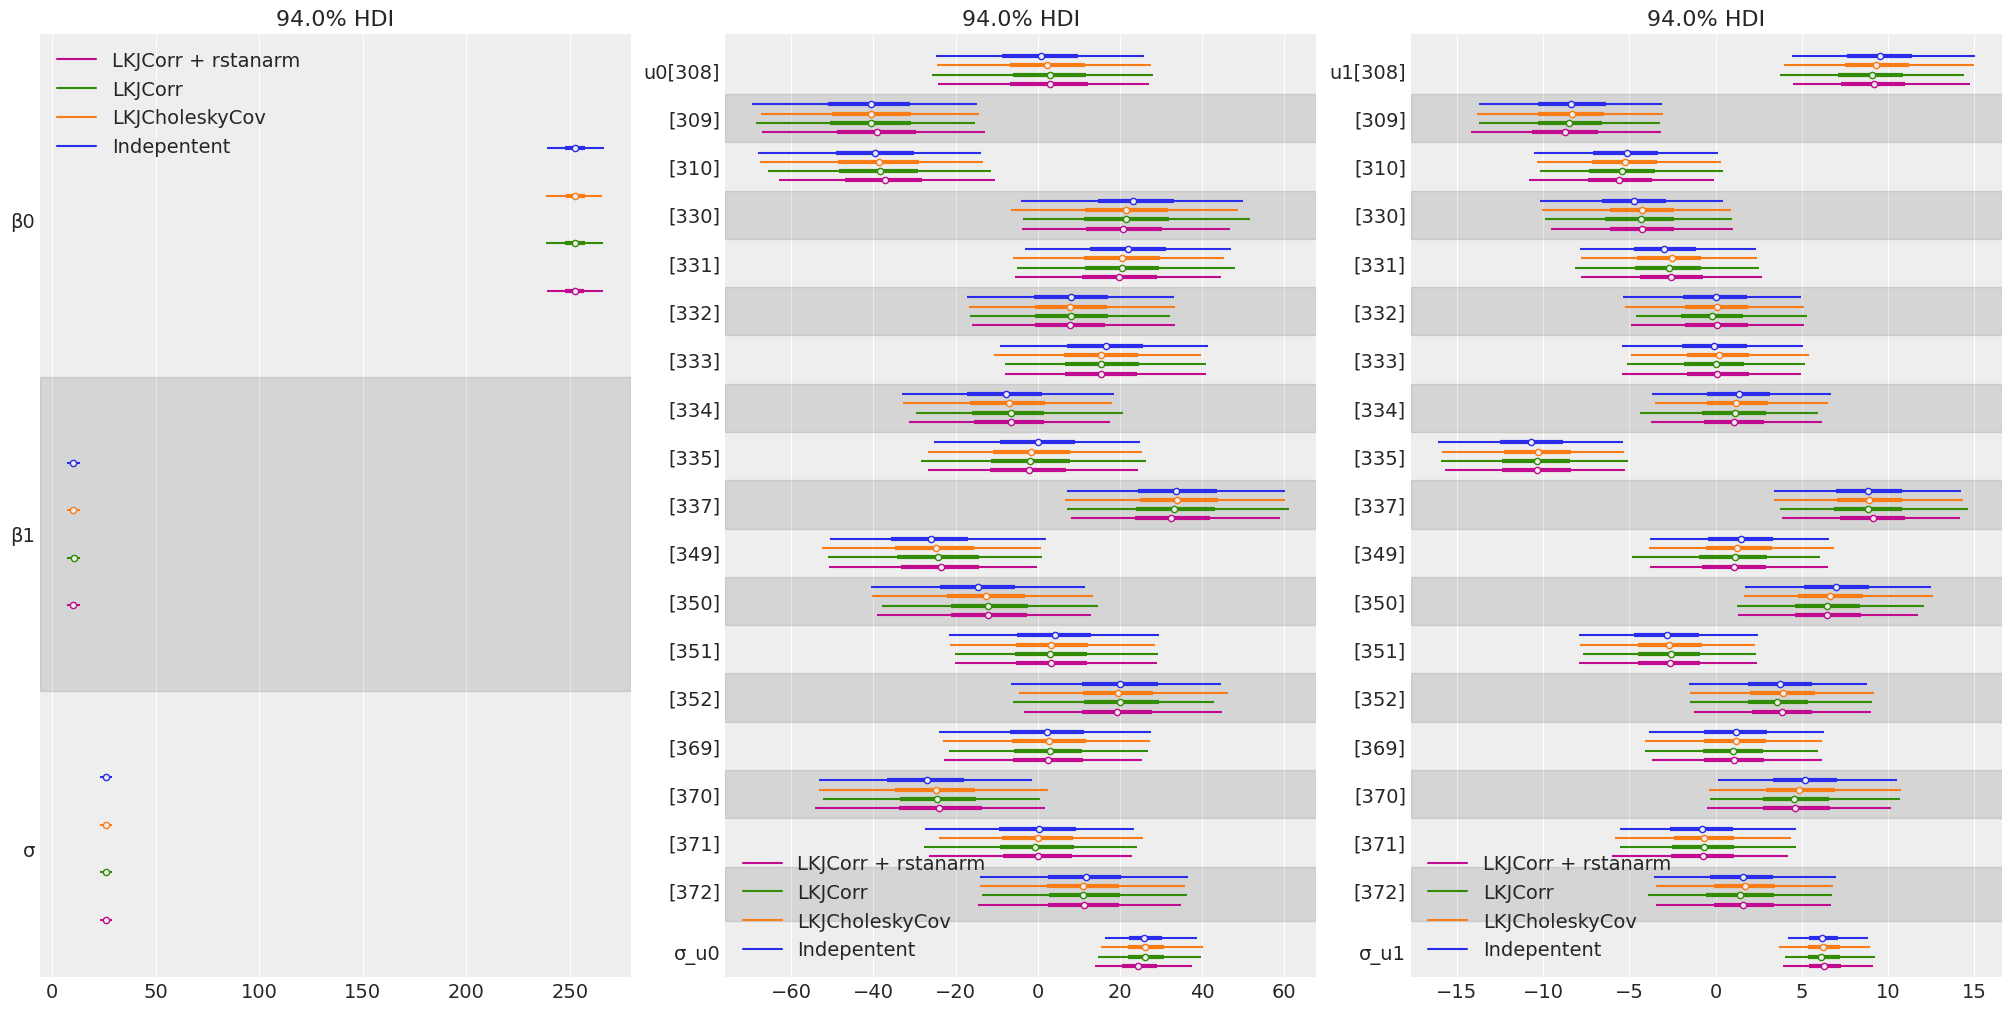

In [31]:
groups = [
    ["β0", "β1", "σ"],
    ["u0", "σ_u0"],
    ["u1", "σ_u1"],
]

model_names = ["Indepentent", "LKJCholeskyCov", "LKJCorr", "LKJCorr + rstanarm"]
fig, ax = plt.subplots(1, 3, figsize = (20, 10))

for idx, group in enumerate(groups):
    az.plot_forest(
        [idata_independent, idata_lkj_cov, idata_lkj_corr, idata_lkj_corr_2],
        model_names=model_names,
        var_names=group,
        combined=True,
        ax=ax[idx],
    )

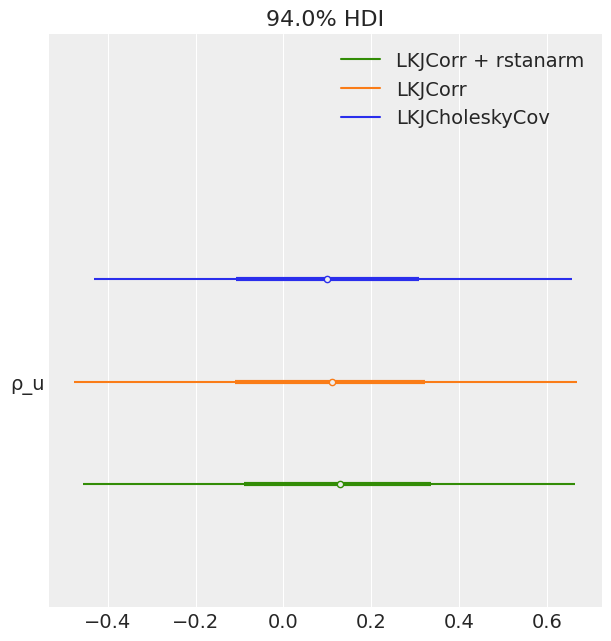

In [32]:
az.plot_forest(
    [idata_lkj_cov, idata_lkj_corr, idata_lkj_corr_2],
    model_names=model_names[1:],
    var_names=["ρ_u"],
    combined=True
);

## Conclusions

### Conclusions

* We showed how to use correlated priors for group-specific coefficients.
* The posteriors resulted to be the same for the in all the cases.
* The correlated priors didn't imply any benefit to our sampling process. However, this could be beneficial for more complex hierarchical models. 
* What's more, the model with the correlated priors took more time to sample than the one with independent priors.
* Attempting to replicate rstanarm approach takes even longer because we are forced to compute many things manually.

### Notes and suggestions

* Sometimes, the models with correlated priors based on `pm.LKJCorr` resulted in divergences. We needed to increase `target_accept`.
* It would be good to be able to pass a random variable to `sd_dist` in `pm.LKJCholeskyCov`, and not just a stateless distribution. This forced me to use `pm.LKJCorr` and perform many manipulations manually, which was more error-prone and inefficient.
* It would be good to check if there's something in the LKJCorr/LKJCholeskyCov that could be improved. I plan to use `LKJCholeskyCov` within [Bambi](https://github.com/bambinos/bambi) in the future and I would like it to work as better as possible.

In [33]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jun 12 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

numpy     : 1.21.6
pandas    : 1.4.2
matplotlib: 3.5.2
arviz     : 0.12.1
aesara    : 2.6.6
pymc      : 4.0.0
sys       : 3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:39:04) [GCC 10.3.0]

Watermark: 2.3.1

